In [4]:
import pickle
from copy import deepcopy

import matplotlib.pyplot as plt
from numpy import linspace

from utils import (
    calculate_score,
    count_nonzero_parameters,
    get_macs,
    get_test_cifar10_dataloader,
    load_trained_model,
    run_global_pruning,
)

In [2]:
testloader = get_test_cifar10_dataloader()

In [3]:
model, og_acc = load_trained_model()
params_ref = count_nonzero_parameters(model)
ops_ref = get_macs(model)

### Global Pruning

In [ ]:
# Half quantisation
model.half() 

prune_amounts = linspace(0.1, 1, 10)
quant_glob_prun_scores = []
for amount in prune_amounts[:-1]:
    pruning_model = deepcopy(model)
    n_params, acc = run_global_pruning(pruning_model, testloader, amount, half=True)
    score = calculate_score(
        0, 1 - (n_params / params_ref), 32, 32, n_params, get_macs(pruning_model, half=True), params_ref, ops_ref
    )
    quant_glob_prun_scores.append((score, acc))

Text(0.5, 1.0, 'Global Pruning Accuracy v Score')

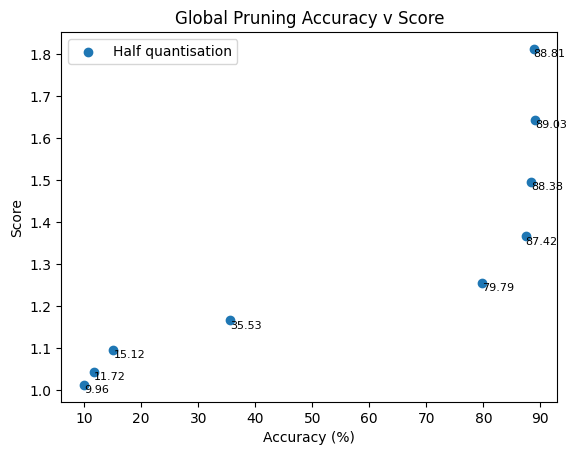

In [10]:
accs = [i[1] for i in quant_glob_prun_scores]
scores = [i[0] for i in quant_glob_prun_scores]
plt.scatter(accs, scores, label="Half quantisation")

for i, (xi, yi) in enumerate(zip(accs, scores)):
    plt.text(xi, yi, f"{accs[i]:.2f}", fontsize=8, ha='left', va='top')

plt.legend()
plt.xlabel("Accuracy (%)")
plt.ylabel("Score")
plt.title("Global Pruning Accuracy v Score")

### Gradual Pruning

In [20]:
with open("gradual_prune_half_quant_res.pkl", "rb") as f:
    res = pickle.load(f)

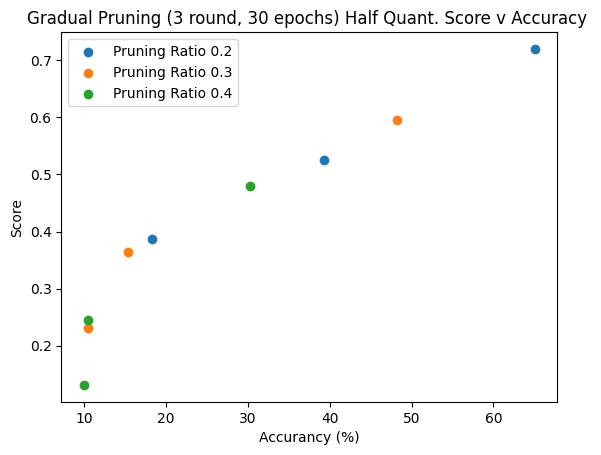

In [24]:
grad_prune_res = {}
for ratio, list_ in res.items():
    list_2 = []
    accs = []
    for i, tup in enumerate(list_):
        score = calculate_score(
            1 - (1 * (1 - ratio) ** (i + 1)), 0, 16, 16, 6956297 * ((1 - ratio) ** (i + 1)), ops_ref, params_ref, ops_ref,
        )
        list_2.append(score)
        accs.append(tup[1])
    grad_prune_res[ratio] = {"scores": list_2, "accs": accs}

r1_x = grad_prune_res[0.2]["accs"]
r1_y = grad_prune_res[0.2]["scores"]

r2_x = grad_prune_res[0.3]["accs"]
r2_y = grad_prune_res[0.3]["scores"]

r3_x = grad_prune_res[0.4]["accs"]
r3_y = grad_prune_res[0.4]["scores"]

plt.scatter(r1_x, r1_y, label="Pruning Ratio 0.2")
plt.scatter(r2_x, r2_y, label="Pruning Ratio 0.3")
plt.scatter(r3_x, r3_y, label="Pruning Ratio 0.4")
plt.title("Gradual Pruning (3 round, 30 epochs) Half Quant. Score v Accuracy ")
plt.xlabel("Accurancy (%)")
plt.ylabel("Score")
plt.legend()

### ThiNet Pruning

Text(0, 0.5, 'Score')

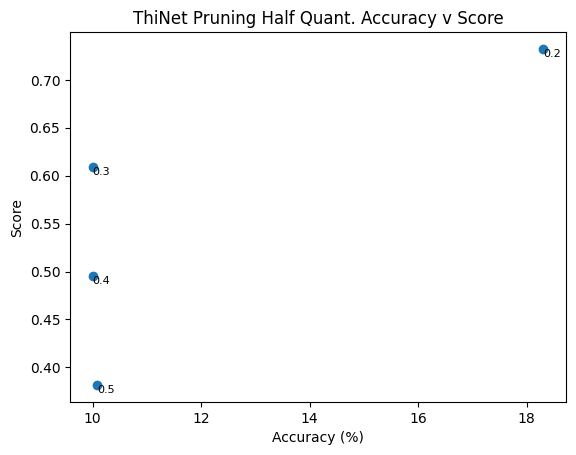

In [19]:
with open("thinet_prune_half_quant.pkl", "rb") as f:
    res = pickle.load(f)

x = [r[1] for r in res]
y = [r[2] for r in res]

plt.scatter(x, y)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi, f"{res[i][0]}", fontsize=8, ha='left', va='top')


plt.title("ThiNet Pruning Half Quant. Accuracy v Score")
plt.xlabel("Accuracy (%)")
plt.ylabel("Score")

In [15]:
model

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_sta